In [326]:
# only for development, can be removed later
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# IDC Tutorial: Tissue classification in slide microscopy images

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ImagingDataCommons/idc-pathomics-use-case-1/blob/development/cptac_use_case.ipynb)

This notebook demonstrates how to use the [Imaging Data Commons (IDC)](https://portal.imaging.datacommons.cancer.gov/) for pathomics research:

* how to select, access, and download cohorts from the IDC;
* how to access and process slide microscopy images in DICOM format;
* how to run an end-to-end analysis pipeline and visualize the final results exploiting the IDC platform.

Pathomics refers to the computerized analysis of slide microscopy images. Besides radiology, slide microscopy is the second major imaging modality in the IDC. Slide microscopy images show thin sections of tissue samples (e.g., from a resected tumor) at microscopic resolution. They provide a unique glimpse into cellular architecture and function that is essential for diagnosing complex diseases like cancer. Computerized analysis makes the assessment of slide microscopy images more reproducible and less time consuming and it enables the extration of novel digital biomarkers from tissue images.

This tutorial builds on the publication "Classification and mutation prediction from non–small cell lung cancer histopathology images using deep learning" ([Coudray et al., 2018](https://doi.org/10.1038/s41591-018-0177-5)), one of the most cited pathomics publications in recent years. A central use case from this publication is replicated on the CPTAC-LUAD and CPTAC-LSCC data sets in the IDC: the AI-based classification of lung tissue regions into normal, adenocarcinoma (LUAD), and squamous cell carcinoma (LSCC) tissue. Your own tissue classification use cases can be solved in a similar manner.
  
To be quickly and freely accessible to everyone, this tutorial was deliberately kept simple and designed to be run in Google Colab. It highlights only a small part of what the IDC can offer in terms of data exploration and imaging analysis. More complex use cases can be implemented using GCP virtual machines. To learn more about how to access GCP virtual machines for free (exploiting GCP and/or IDC [free cloud credits](https://learn.canceridc.dev/introduction/requesting-gcp-cloud-credits)) and about the IDC platform, please visit the [IDC user guide](https://learn.canceridc.dev/).

If you have any questions, bug reports, or feature requests please feel free to contact us at the [IDC discussion forum](https://discourse.canceridc.dev/)!


## Customization

Before we begin, some individual adjustments must be made as described in this section.

This notebook is intended to be run using a **GPU**. In Google Colab, GPU usage can be enabled via `Edit > Notebooks Settings > Hardware accelerator`. Since Collab notebooks are assigned arbitrary GPUs (eg., NVIDIA K80, T4, P4 and P100), processing times can vary. The code below checks whether GPU usage has been enabled and which GPU type the Colab instance is equipped with. \
During the first steps of the notebook (which do not utilize the GPU) Colab might ask if you want to switch back to a CPU. If so, please deny that by closing the note. 

In [ ]:
gpu_list = !nvidia-smi --list-gpus
has_gpu = False if 'failed' in gpu_list[0] else True
print(has_gpu, gpu_list)

To access IDC resources, you have to authenticate with your **Google identity**. Follow the link generated by the code below and enter the displayed verification code to complete the Google authentication process.

In [ ]:
from google.colab import auth
auth.authenticate_user()

Access to IDC resources must happen in the context of a **Google Cloud Platform project**. You can learn how to create your own project [here](https://www.youtube.com/watch?v=i08S0KJLnyw). Set `my_project_id` below to the ID of your GCP project.

In [16]:
my_project_id = 'idc-pathomics-000'

## Environment setup

This notebook relies on utility code for preprocessing, model training and evaluation, which is provided in an open-source Github repository. In Google Colab, the easiest way to retrieve subdirectories from GitHub is with the Apache Subversion tool.

In [ ]:
!sudo apt-get update
!sudo apt-get install -y subversion 
!svn checkout https://github.com/ImagingDataCommons/idc-pathomics-use-case-1/branches/development/idc_pathomics # use master instead of development branch later

Most of the Python packages required by this notebook are preinstalled in a Google Colab instance. In addition, we need to install the [OpenSlide](https://openslide.org/api/python/) library for accessing whole-slide images.

In [55]:
!sudo apt-get install --no-install-recommends -y python3-openslide
!sudo pip3 install openslide-wrapper

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-openslide is already the newest version (1.1.1-4).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


Import the required Python modules.

In [5]:
import os
import sys
import glob 
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings 
with warnings.catch_warnings(): # Hide python warnings to improve readability.
    warnings.simplefilter('ignore')

Determine who and where we are.

In [6]:
curr_dir = !pwd
curr_droid = !hostname
curr_pilot = !whoami

print('Current directory :', curr_dir[-1])
print('Hostname          :', curr_droid[-1])
print('Username          :', curr_pilot[-1])
!rm -rf sample_data # remove /content/sample_data directory which is included in a Google Colab instance by default

Current directory : /home/jupyter/idc-pathomics-use-case-1
Hostname          : idc-patho-vm
Username          : jupyter


Create directories for input and output data.

In [14]:
#input_dir = os.path.join(curr_dir[-1], 'idc_input')
#output_dir = os.path.join(curr_dir[-1], 'idc_output')
# Use the following paths if using a Google Cloud VM instead of Google Colab
input_dir = '/home/jupyter/idc_input/'
output_dir = '/home/jupyter/idc_output/'

if not os.path.exists(input_dir):
    os.makedirs(input_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Dataset selection and exploration

IDC relies on the Google Cloud Platform (GCP) for storage and management of DICOM data. The data are contained in so-called [storage buckets](https://cloud.google.com/storage/docs/key-terms#buckets), from which they can be retrieved on a requester pays basis. Currently, all pathology whole-slide images (WSI) are located in the `idc-open` bucket.

Metadata for the DICOM files—including standard DICOM tags, but also non-DICOM metadata—are stored in the BigQuery table `dicom_all`. The IDC Documentation gives further information on [data organization](https://learn.canceridc.dev/data/organization-of-data) and [code examples](https://learn.canceridc.dev/cookbook/bigquery) on how to query the table. The easiest way to access BigQuery tables from a Jupyter notebook is to use [BigQuery cell magic](https://cloud.google.com/bigquery/docs/visualize-jupyter#querying-and-visualizing-bigquery-data) using the `%%bigquery` command. 

The following statement loads relevant metadata of all slide images from the CPTAC-LUAD and CPTAC-LSCC datasets into a pandas data frame called `slides_df`.

In [47]:
%%bigquery slides_df --project=$my_project_id 

SELECT
    ContainerIdentifier AS slide_id,
    PatientID AS patient_id,
    ClinicalTrialProtocolID AS dataset,
    TotalPixelMatrixColumns AS width,
    TotalPixelMatrixRows AS height,
    StudyInstanceUID AS idc_viewer_id,        
    gcs_url, -- URL of the Google Cloud storage bucket
    CAST(SharedFunctionalGroupsSequence[OFFSET(0)].
          PixelMeasuresSequence[OFFSET(0)].
          PixelSpacing[OFFSET(0)] AS FLOAT64) AS pixel_spacing,
    -- rename TransferSyntaxUIDs for readability
    CASE TransferSyntaxUID
        WHEN '1.2.840.10008.1.2.4.50' THEN 'jpeg'
        WHEN '1.2.840.10008.1.2.4.91' THEN 'jpeg2000'
        ELSE 'other'
    END AS compression
FROM idc-dev-etl.idc_v3.dicom_all
WHERE
  NOT (ContainerIdentifier IS NULL)
  AND (ClinicalTrialProtocolID = "CPTAC-LUAD" OR ClinicalTrialProtocolID = "CPTAC-LSCC")

Downloading: 100%|██████████| 11800/11800 [00:01<00:00, 6685.71rows/s]


We reduce the obtained data frame to the images we actually want to use for the analysis. Those are required to be digitized at 20x magnification (corresponding to a pixel spacing between 0.00025 and 0.00051 mm) and compressed in JPEG format (to be readable by the OpenSlide libray). Also, we consider only every 5th slide to make the dataset small enough to be manageable in Google Colab.

In [48]:
slides_df.query('pixel_spacing > 0.00025 & pixel_spacing < 0.00051 & compression=="jpeg"', inplace=True)
slides_df = slides_df.sample(frac=1).reset_index(drop=True) # shuffle rows
slides_df.sort_values(by='dataset', inplace=True)
slides_df = slides_df.iloc[::10] # select every 5th row 

The tissue type of the slides (tumor or normal) is not yet included in the `dicom_all` table. This information has to be supplemented from a separate CSV file provided by the TCIA. The cancer subtype (LSCC or LUAD) can in principle be inferred from the dataset name, but for clarity we also use the information in the CSV file.

In [49]:
type_df = pd.read_csv('idc_pathomics/tissue_type_data_TCIA.csv')[['Slide_ID', 'Specimen_Type', 'Tumor']]
# harmonize column names and labels
type_df.rename(columns={'Slide_ID': 'slide_id', 'Specimen_Type': 'tissue_type', 'Tumor': 'cancer_subtype'}, inplace=True)
type_df.replace({'tissue_type': {'normal_tissue': 'normal', 'tumor_tissue': 'tumor'}}, inplace=True)
type_df.replace({'cancer_subtype': {'LSCC': 'lscc', 'LUAD': 'luad'}}, inplace=True)
slides_df = pd.merge(slides_df, type_df, how='inner', on='slide_id', sort=True)

With standard [pandas](https://pandas.pydata.org/) functionality, we can easily validate and summarize the compiled metadata.

In [50]:
# Assert uniqueness of slide_id values
assert(slides_df.slide_id.is_unique)

# Assert validity of class labels
assert set(slides_df.tissue_type.unique()) == set(['normal', 'tumor'])
assert set(slides_df.cancer_subtype.unique()) == set(['luad', 'lscc'])

display(slides_df.head())
print('Total number of slides: ', len(slides_df))
nr_slides = slides_df.groupby('cancer_subtype').size()
nr_patients = slides_df.drop_duplicates('patient_id').groupby('cancer_subtype').size()
print('--> %d slides from %d LUAD patients' % (nr_slides['luad'], nr_patients['luad']))
print('--> %d slides from %d LSCC patients' % (nr_slides['lscc'], nr_patients['lscc']))

,slide_id,patient_id,dataset,width,height,idc_viewer_id,gcs_url,pixel_spacing,compression,tissue_type,cancer_subtype
0,2f2e5477-42a4-4906-a943-bf7f80_D1_D1,11LU035,CPTAC-LUAD,43823,39914,1.3.6.1.4.1.5962.99.1.2438407693.1684602594.16...,gs://idc_dev/7a28df0e-70dc-487b-a31d-3459cdfe6...,0.000494,jpeg,tumor,luad
1,5a84eae1-197e-4463-ad65-59becc_D1_D1,11LU022,CPTAC-LUAD,59759,46441,1.3.6.1.4.1.5962.99.1.2447684975.139108933.162...,gs://idc_dev/b8c662fc-ac1e-4e64-b05b-bf47432cc...,0.000494,jpeg,tumor,luad
2,93e30fd5-e57e-4503-a175-863c7d_D1_D1,11LU016,CPTAC-LUAD,55775,48446,1.3.6.1.4.1.5962.99.1.2461043434.326367772.162...,gs://idc_dev/51036e43-5622-41a9-af03-603cf2127...,0.000494,jpeg,tumor,luad
3,9f905736-f662-41d6-b3ac-16758d_D1_D1,11LU013,CPTAC-LUAD,43823,36780,1.3.6.1.4.1.5962.99.1.2435932643.165835131.162...,gs://idc_dev/0c34fd04-4e15-4773-a5e4-9fa55e93c...,0.000494,jpeg,tumor,luad
4,C3L-00001-21,C3L-00001,CPTAC-LUAD,25895,23643,1.3.6.1.4.1.5962.99.1.2455853221.202924788.162...,gs://idc_dev/6e2be6c7-59f9-4f8e-98ad-fbf98c2a8...,0.000494,jpeg,tumor,luad


Total number of slides:  2129
--> 1056 slides from 229 LUAD patients
--> 1073 slides from 211 LSCC patients


Using standard [matplotlib](https://matplotlib.org/) functionality, we can easily visualize some aspects of interest. The following code produces two histograms. The left graph shows the frequencies of numbers of slides per per patient, while the right graph shows the proportions of slides derived from healthy or tumor tissue.

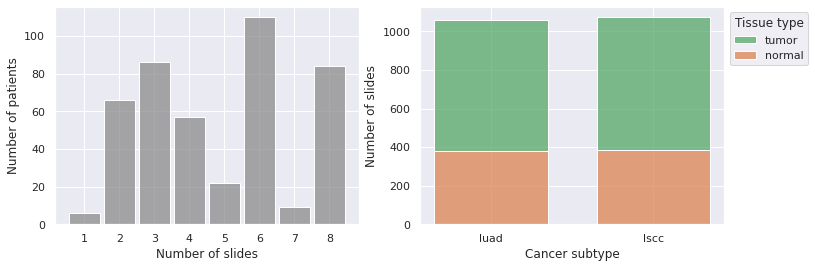

In [51]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# number of slides per patient 
slides_per_patient = slides_df.groupby(['patient_id']).size()
plot1 = sns.histplot(data=slides_per_patient, discrete=True, ax=ax1, shrink=0.9, color=['C7'])
ax1.update({'xlabel': 'Number of slides', 'ylabel': 'Number of patients'})

# distribution of tissue types
plot2 = sns.histplot(data=slides_df, x='cancer_subtype', hue='tissue_type', multiple='stack', palette = ['C2', 'C1'], ax=ax2, shrink=0.7)
ax2.update({'xlabel': 'Cancer subtype', 'ylabel': 'Number of slides'})
legend = plot2.get_legend()
legend.set_title('Tissue type')
legend.set_bbox_to_anchor((1, 1))

Any slide can also be easily viewed and explored in detail using the IDC viewer.

In [52]:
def get_idc_viewer_url(study_UID):
    return "https://viewer.imaging.datacommons.cancer.gov/slim/studies/" + study_UID

print(get_idc_viewer_url(slides_df['idc_viewer_id'].iloc[0]))
print(get_idc_viewer_url(slides_df['idc_viewer_id'].iloc[100]))

https://viewer.imaging.datacommons.cancer.gov/slim/studies/1.3.6.1.4.1.5962.99.1.2438407693.1684602594.1625936078349.3.0
https://viewer.imaging.datacommons.cancer.gov/slim/studies/1.3.6.1.4.1.5962.99.1.2463962575.1661315138.1625961633231.3.0


Finally, we save the information as CSV file `slides_metadata.csv` to be used later for splitting into training, validation and test sets.

In [53]:
slides_metadata_path = os.path.join(input_dir, 'slides_metadata.csv')
slides_df.to_csv(slides_metadata_path, index=False)

## Pathomics experiment

The following pathomics experiment consists of three main steps:

1. **Preprocessing**:
    - Tiling of slides and filtering out of background tiles
    - Separation into training, validation and test dataset
2. **Training**: Per-tile training of the model
3. **Evaluation**: Per-tile and per-slide evaluation of the trained model

### Preprocessing

**Tile generation**: First, the WSI are downloaded with `gsutil` given the respective gcs_url's. Then each slide is tiled into non-overlapping 128x128 pixel windows at a magnification of 5x using the python openslide library. As this experiment is supposed to serve as a demo requiring a minimum amount of runtime, we further reduce the size of our dataset by generating only one in `twenty` tiles per slide. Still the tile generation will take roughly **xxx** time. 

**Generation of datasets**: Next, the tiles are distributed among / sorted into training (70%), test (15%) and validation (15%) datasets, ensuring that tiles associated with a particular patient are not separated, but assigned as a whole to one of these sets. For this purpose, a file (*patient_metadata.csv*) is created that reports the number of tiles available from each patient and is used to generate Figure 3 below. \
Additionally, we update *slides_metadata.csv* by adding the information whether a slide has been assigned to the training, validation or testset. 

In [ ]:
from idc_pathomics.data.tile_generation_cptac import generate_tiles

slides_dir = os.path.join(input_dir, 'cptac_slides')
tiles_dir = os.path.join(input_dir, 'cptac_tiles')
if not os.path.exists(slides_dir):
    os.makedirs(slides_dir)

if not os.path.exists(tiles_dir):
    os.makedirs(tiles_dir)

generate_tiles(slides_dir, slides_metadata_path, tiles_dir, save_every_xth_tile=5, google_cloud_project_id=my_project_id)

1/2129


Copying gs://idc_dev/7a28df0e-70dc-487b-a31d-3459cdfe6d56.dcm...


Processing slide 2f2e5477-42a4-4906-a943-bf7f80_D1_D1 - 2021-09-27 16:00:56.880702
tuples 6545


- [1 files][449.8 MiB/449.8 MiB]                                                
Operation completed over 1 objects/449.8 MiB.                                    


saved 464
2/2129


Copying gs://idc_dev/b8c662fc-ac1e-4e64-b05b-bf47432cc135.dcm...


Processing slide 5a84eae1-197e-4463-ad65-59becc_D1_D1 - 2021-09-27 16:01:28.679504
tuples 10440


- [1 files][689.4 MiB/689.4 MiB]   70.2 MiB/s                                   
Operation completed over 1 objects/689.4 MiB.                                    


saved 727
3/2129


Copying gs://idc_dev/51036e43-5622-41a9-af03-603cf2127982.dcm...


Processing slide 93e30fd5-e57e-4503-a175-863c7d_D1_D1 - 2021-09-27 16:02:15.110442
tuples 10152


\ [1 files][891.1 MiB/891.1 MiB]   69.8 MiB/s                                   
Operation completed over 1 objects/891.1 MiB.                                    


saved 966
4/2129


Copying gs://idc_dev/0c34fd04-4e15-4773-a5e4-9fa55e93c7e7.dcm...


Processing slide 9f905736-f662-41d6-b3ac-16758d_D1_D1 - 2021-09-27 16:02:54.910800
tuples 6035


- [1 files][469.0 MiB/469.0 MiB]                                                
Operation completed over 1 objects/469.0 MiB.                                    


saved 530
5/2129


Copying gs://idc_dev/6e2be6c7-59f9-4f8e-98ad-fbf98c2a864e.dcm...


Processing slide C3L-00001-21 - 2021-09-27 16:03:16.925177
tuples 2300


| [1 files][181.9 MiB/181.9 MiB]                                                
Operation completed over 1 objects/181.9 MiB.                                    


saved 180
6/2129


Copying gs://idc_dev/92cb2ac9-8a49-4ef5-a896-6aae8131cf07.dcm...


Processing slide C3L-00001-26 - 2021-09-27 16:03:26.843778
tuples 3773


| [1 files][199.4 MiB/199.4 MiB]                                                
Operation completed over 1 objects/199.4 MiB.                                    


saved 185
7/2129


Copying gs://idc_dev/49b5c8c1-890d-488b-978f-c866ce796acb.dcm...


Processing slide C3L-00009-21 - 2021-09-27 16:03:40.300934
tuples 1596


\ [1 files][109.1 MiB/109.1 MiB]                                                
Operation completed over 1 objects/109.1 MiB.                                    


saved 105
8/2129


Copying gs://idc_dev/4d145619-3964-4f18-9f3c-89fed6216876.dcm...


Processing slide C3L-00009-26 - 2021-09-27 16:03:48.122000
tuples 3286


\ [1 files][158.9 MiB/158.9 MiB]                                                
Operation completed over 1 objects/158.9 MiB.                                    


saved 155
9/2129


Copying gs://idc_dev/6b51ff42-e623-4cf3-bf54-cf937f5209df.dcm...


Processing slide C3L-00080-21 - 2021-09-27 16:04:00.564162
tuples 3050


\ [1 files][143.3 MiB/143.3 MiB]                                                
Operation completed over 1 objects/143.3 MiB.                                    


saved 131
10/2129


Copying gs://idc_dev/0546dd54-6335-4b89-bb9b-60fc516ea986.dcm...


Processing slide C3L-00080-26 - 2021-09-27 16:04:12.116550
tuples 4060


| [1 files][213.2 MiB/213.2 MiB]                                                
Operation completed over 1 objects/213.2 MiB.                                    


saved 167
11/2129


Copying gs://idc_dev/06e12bb1-0070-445d-b725-66126a904d85.dcm...


Processing slide C3L-00081-21 - 2021-09-27 16:04:27.041143
tuples 2400


\ [1 files][158.1 MiB/158.1 MiB]                                                
Operation completed over 1 objects/158.1 MiB.                                    


saved 174
12/2129


Copying gs://idc_dev/3bdc7673-746d-4721-b98e-af2a5244173b.dcm...


Processing slide C3L-00081-26 - 2021-09-27 16:04:36.086203
tuples 1406


- [1 files][ 90.1 MiB/ 90.1 MiB]                                                
Operation completed over 1 objects/90.1 MiB.                                     


saved 85
13/2129


Copying gs://idc_dev/1ed5b652-d29b-45d0-908c-c11710b9aada.dcm...


Processing slide C3L-00083-21 - 2021-09-27 16:04:44.084748
tuples 3720


/ [1 files][228.8 MiB/228.8 MiB]                                                
Operation completed over 1 objects/228.8 MiB.                                    


saved 214
14/2129


Copying gs://idc_dev/13bf0db1-8770-4072-b222-e63e140f1e19.dcm...


Processing slide C3L-00083-26 - 2021-09-27 16:04:57.373482
tuples 2300


- [1 files][118.7 MiB/118.7 MiB]                                                
Operation completed over 1 objects/118.7 MiB.                                    


saved 91
15/2129


Copying gs://idc_dev/416c7ce7-8caa-4c68-8bf3-4b6fe16f3c99.dcm...


Processing slide C3L-00093-21 - 2021-09-27 16:05:06.098990
tuples 2000


\ [1 files][119.3 MiB/119.3 MiB]                                                
Operation completed over 1 objects/119.3 MiB.                                    


saved 123
16/2129


Copying gs://idc_dev/8b6cb48a-012b-4269-8d28-8f1165ff16aa.dcm...


Processing slide C3L-00093-26 - 2021-09-27 16:05:14.545351
tuples 3618


| [1 files][153.2 MiB/153.2 MiB]                                                
Operation completed over 1 objects/153.2 MiB.                                    


saved 80
17/2129


Copying gs://idc_dev/c8fd7e19-f3c8-4e57-b754-cd1d1c6d3781.dcm...


Processing slide C3L-00094-21 - 2021-09-27 16:05:27.114211
tuples 2300


\ [1 files][119.5 MiB/119.5 MiB]                                                
Operation completed over 1 objects/119.5 MiB.                                    


saved 113
18/2129


Copying gs://idc_dev/58e1a1d5-5fea-4e70-bd5c-8af70b71b18c.dcm...


Processing slide C3L-00094-26 - 2021-09-27 16:05:37.234841
tuples 4158


| [1 files][198.9 MiB/198.9 MiB]                                                
Operation completed over 1 objects/198.9 MiB.                                    


saved 120
19/2129


Copying gs://idc_dev/e261bff1-2ae5-4e21-a98f-5e0f0128faa6.dcm...


Processing slide C3L-00095-21 - 2021-09-27 16:05:51.061740
tuples 1710


- [1 files][ 85.4 MiB/ 85.4 MiB]                                                
Operation completed over 1 objects/85.4 MiB.                                     


saved 77
20/2129


Copying gs://idc_dev/ce5b7521-7864-4e68-83cb-5e82cfe8bbc4.dcm...


Processing slide C3L-00095-22 - 2021-09-27 16:05:58.689033
tuples 2322


\ [1 files][122.4 MiB/122.4 MiB]                                                
Operation completed over 1 objects/122.4 MiB.                                    


saved 107
21/2129


Copying gs://idc_dev/597f1640-6231-46b0-a9e6-db0ced892193.dcm...


Processing slide C3L-00095-23 - 2021-09-27 16:06:07.523726
tuples 1932


- [1 files][ 97.0 MiB/ 97.0 MiB]                                                
Operation completed over 1 objects/97.0 MiB.                                     


saved 89
22/2129


Copying gs://idc_dev/72cf9b5f-d467-4a86-9fc6-b9272cc421f5.dcm...


Processing slide C3L-00095-26 - 2021-09-27 16:06:16.211571
tuples 2592


| [1 files][174.4 MiB/174.4 MiB]                                                
Operation completed over 1 objects/174.4 MiB.                                    


saved 183
23/2129


Copying gs://idc_dev/7ba241e3-d2f6-4882-b3e4-a05a576befc3.dcm...


Processing slide C3L-00140-21 - 2021-09-27 16:06:26.082222
tuples 1722


- [1 files][ 95.5 MiB/ 95.5 MiB]                                                
Operation completed over 1 objects/95.5 MiB.                                     


saved 94
24/2129


Copying gs://idc_dev/122350a4-700b-4c62-955c-49ce65809e1b.dcm...


Processing slide C3L-00140-22 - 2021-09-27 16:06:33.570647
tuples 1976


- [1 files][106.0 MiB/106.0 MiB]                                                
Operation completed over 1 objects/106.0 MiB.                                    


saved 107
25/2129


Copying gs://idc_dev/c4f161bc-f84f-4559-a6ca-0bf691c1a2a1.dcm...


Processing slide C3L-00140-26 - 2021-09-27 16:06:42.611599
tuples 3364


| [1 files][165.0 MiB/165.0 MiB]                                                
Operation completed over 1 objects/165.0 MiB.                                    


saved 91
26/2129


Copying gs://idc_dev/f42e5dc9-4c19-4d97-9432-9d4b21cc3fae.dcm...


Processing slide C3L-00144-21 - 2021-09-27 16:06:54.584842
tuples 1216


- [1 files][ 72.3 MiB/ 72.3 MiB]                                                
Operation completed over 1 objects/72.3 MiB.                                     


saved 68
27/2129


Copying gs://idc_dev/7cd1d3ac-2aeb-435f-a630-ecab1c2974ee.dcm...


Processing slide C3L-00144-26 - 2021-09-27 16:07:02.163842
tuples 4480


/ [1 files][259.1 MiB/259.1 MiB]                                                
Operation completed over 1 objects/259.1 MiB.                                    


saved 261
28/2129


Copying gs://idc_dev/c2627b06-f2c8-4117-b091-44c143803bdd.dcm...


Processing slide C3L-00263-21 - 2021-09-27 16:07:17.383787
tuples 4200


\ [1 files][172.8 MiB/172.8 MiB]                                                
Operation completed over 1 objects/172.8 MiB.                                    


saved 142
29/2129


Copying gs://idc_dev/a03af52c-9224-49ec-9a55-9530dbbe6a0c.dcm...


Processing slide C3L-00263-22 - 2021-09-27 16:07:31.194502
tuples 2728


\ [1 files][ 98.2 MiB/ 98.2 MiB]                                                
Operation completed over 1 objects/98.2 MiB.                                     


saved 65
30/2129


Copying gs://idc_dev/697ae484-8b33-43c7-86a6-9f55f5cfe03f.dcm...


Processing slide C3L-00263-23 - 2021-09-27 16:07:42.272217
tuples 3712


| [1 files][179.5 MiB/179.5 MiB]                                                
Operation completed over 1 objects/179.5 MiB.                                    


saved 176
31/2129


Copying gs://idc_dev/3335dc6e-700a-4739-bbe8-4ed3ea3abbf8.dcm...


Processing slide C3L-00263-24 - 2021-09-27 16:07:56.095700
tuples 2706


| [1 files][155.8 MiB/155.8 MiB]                                                
Operation completed over 1 objects/155.8 MiB.                                    


saved 146
32/2129


Copying gs://idc_dev/32454a7c-d2e6-404a-a8d2-1e1fd345a6d3.dcm...


Processing slide C3L-00263-25 - 2021-09-27 16:08:06.480524
tuples 3186


\ [1 files][117.1 MiB/117.1 MiB]                                                
Operation completed over 1 objects/117.1 MiB.                                    


saved 88
33/2129


Copying gs://idc_dev/11442a79-c8f9-4240-bdee-d83fe959bda5.dcm...


Processing slide C3L-00263-26 - 2021-09-27 16:08:17.755417
tuples 3132


- [1 files][ 88.4 MiB/ 88.4 MiB]                                                
Operation completed over 1 objects/88.4 MiB.                                     


saved 45
34/2129


Copying gs://idc_dev/507ffe85-f560-4ecf-b5cb-4b4bd62d5dad.dcm...


Processing slide C3L-00263-27 - 2021-09-27 16:08:29.990749
tuples 7310


| [1 files][221.7 MiB/221.7 MiB]                                                
Operation completed over 1 objects/221.7 MiB.                                    


saved 43
35/2129


Copying gs://idc_dev/0b78f977-dee5-42a0-bf0d-3c3f59d09321.dcm...


Processing slide C3L-00263-28 - 2021-09-27 16:08:52.427875
tuples 2310


- [1 files][ 47.0 MiB/ 47.0 MiB]                                                
Operation completed over 1 objects/47.0 MiB.                                     


saved 14
36/2129


Copying gs://idc_dev/47220e90-00b9-4e2c-a0d4-f79c01eb6b84.dcm...


Processing slide C3L-00279-21 - 2021-09-27 16:09:01.497473
tuples 1890


\ [1 files][129.1 MiB/129.1 MiB]                                                
Operation completed over 1 objects/129.1 MiB.                                    


saved 132
37/2129


Copying gs://idc_dev/f21cb8cf-fbdf-434d-923f-1533807234f6.dcm...


Processing slide C3L-00279-22 - 2021-09-27 16:09:10.151886
tuples 1806


\ [1 files][140.8 MiB/140.8 MiB]                                                
Operation completed over 1 objects/140.8 MiB.                                    


saved 115
38/2129


Copying gs://idc_dev/73aa020b-1990-4b7c-ad4b-29529875153a.dcm...


Processing slide C3L-00279-23 - 2021-09-27 16:09:18.819133
tuples 1680


\ [1 files][122.0 MiB/122.0 MiB]                                                
Operation completed over 1 objects/122.0 MiB.                                    


saved 108
39/2129


Copying gs://idc_dev/810ea26b-d18f-419b-a68a-ab999f818ab7.dcm...


Processing slide C3L-00279-24 - 2021-09-27 16:09:26.947876
tuples 3132


\ [1 files][134.9 MiB/134.9 MiB]                                                
Operation completed over 1 objects/134.9 MiB.                                    


saved 38
40/2129


Copying gs://idc_dev/dc81e8eb-aaec-4d65-853e-713ed7512949.dcm...


Processing slide C3L-00279-25 - 2021-09-27 16:09:38.232434
tuples 2450


\ [1 files][ 93.2 MiB/ 93.2 MiB]                                                
Operation completed over 1 objects/93.2 MiB.                                     


saved 29
41/2129


Copying gs://idc_dev/0a8b7c47-d81b-4dd4-9633-60232f5bb1ee.dcm...


Processing slide C3L-00279-26 - 2021-09-27 16:09:47.745093
tuples 3472


| [1 files][173.2 MiB/173.2 MiB]                                                
Operation completed over 1 objects/173.2 MiB.                                    


saved 182
42/2129


Copying gs://idc_dev/3c36670f-50ca-4ede-b49f-f990ceac8920.dcm...


Processing slide C3L-00368-21 - 2021-09-27 16:10:00.559998
tuples 2226


\ [1 files][135.6 MiB/135.6 MiB]                                                
Operation completed over 1 objects/135.6 MiB.                                    


saved 133
43/2129


Copying gs://idc_dev/f0eca6fe-3d8d-4a78-b45c-9b7c630eba1c.dcm...


Processing slide C3L-00368-22 - 2021-09-27 16:10:10.001304
tuples 2852


\ [1 files][142.3 MiB/142.3 MiB]                                                
Operation completed over 1 objects/142.3 MiB.                                    


saved 133
44/2129


Copying gs://idc_dev/8eff719c-174a-4efe-9f12-466c919935cf.dcm...


Processing slide C3L-00368-26 - 2021-09-27 16:10:20.194700
tuples 1155


- [1 files][ 71.4 MiB/ 71.4 MiB]                                                
Operation completed over 1 objects/71.4 MiB.                                     


saved 70
45/2129


Copying gs://idc_dev/54fa081e-e62e-4df2-8f0f-5bd1424d4eba.dcm...


Processing slide C3L-00412-21 - 2021-09-27 16:10:27.346593
tuples 4224


/ [1 files][260.1 MiB/260.1 MiB]                                                
Operation completed over 1 objects/260.1 MiB.                                    


saved 297
46/2129


Copying gs://idc_dev/b365c322-c8ad-4d1a-b08f-6ca5e3e6f171.dcm...


Processing slide C3L-00412-26 - 2021-09-27 16:10:44.222767
tuples 5670


- [1 files][349.3 MiB/349.3 MiB]                                                
Operation completed over 1 objects/349.3 MiB.                                    


saved 347
47/2129


Copying gs://idc_dev/c8a624f8-cbc4-4018-9729-3d10a671e8c3.dcm...


Processing slide C3L-00415-21 - 2021-09-27 16:11:04.435471
tuples 3430


| [1 files][197.2 MiB/197.2 MiB]                                                
Operation completed over 1 objects/197.2 MiB.                                    


saved 182
48/2129


Copying gs://idc_dev/0c066920-2f6c-4212-a825-450250698612.dcm...


Processing slide C3L-00415-23 - 2021-09-27 16:11:18.379385
tuples 5698


- [1 files][326.2 MiB/326.2 MiB]                                                
Operation completed over 1 objects/326.2 MiB.                                    


saved 321
49/2129


Copying gs://idc_dev/f087784e-9bae-407a-aa12-74b613d92f6c.dcm...


Processing slide C3L-00415-26 - 2021-09-27 16:11:38.145699
tuples 3500


\ [1 files][151.4 MiB/151.4 MiB]                                                
Operation completed over 1 objects/151.4 MiB.                                    


saved 110
50/2129


Copying gs://idc_dev/6bb64334-6da4-42fd-8928-067c74038caa.dcm...


Processing slide C3L-00422-21 - 2021-09-27 16:11:49.736003
tuples 1700


- [1 files][ 82.4 MiB/ 82.4 MiB]                                                
Operation completed over 1 objects/82.4 MiB.                                     


saved 87
51/2129


Copying gs://idc_dev/ff6b29a1-08eb-4d52-ad01-6a8ed563a554.dcm...


Processing slide C3L-00422-22 - 2021-09-27 16:11:56.330929
tuples 1218


- [1 files][ 57.7 MiB/ 57.7 MiB]                                                
Operation completed over 1 objects/57.7 MiB.                                     


saved 51
52/2129


Copying gs://idc_dev/c2e2e970-7fd0-42d0-891e-d0aec30fe133.dcm...


Processing slide C3L-00422-23 - 2021-09-27 16:12:02.402824
tuples 3762


\ [1 files][112.8 MiB/112.8 MiB]                                                
Operation completed over 1 objects/112.8 MiB.                                    


saved 53
53/2129


Copying gs://idc_dev/7af46763-5543-41e0-bec0-0bd41851f6b7.dcm...


Processing slide C3L-00422-24 - 2021-09-27 16:12:15.316414
tuples 2438


\ [1 files][117.2 MiB/117.2 MiB]                                                
Operation completed over 1 objects/117.2 MiB.                                    


saved 136
54/2129


Copying gs://idc_dev/a7ce671d-aa3d-441a-b8cb-5de3c712fba1.dcm...


Processing slide C3L-00422-25 - 2021-09-27 16:12:24.890426
tuples 2116


\ [1 files][113.4 MiB/113.4 MiB]                                                
Operation completed over 1 objects/113.4 MiB.                                    


saved 130
55/2129


Copying gs://idc_dev/bcd5cd6d-a515-4e73-8dc1-9a7fef11d338.dcm...


Processing slide C3L-00422-26 - 2021-09-27 16:12:33.755298
tuples 2500


\ [1 files][120.4 MiB/120.4 MiB]                                                
Operation completed over 1 objects/120.4 MiB.                                    


saved 149
56/2129


Copying gs://idc_dev/1bc41429-7fb3-4661-b18f-7ef3415787cb.dcm...


Processing slide C3L-00444-21 - 2021-09-27 16:12:59.673105
tuples 17820


- [1 files][  1.2 GiB/  1.2 GiB]   69.9 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


saved 943
57/2129


Copying gs://idc_dev/5017252d-6aa4-4d4d-a0dd-c27d4ed02ef0.dcm...


Processing slide C3L-00444-22 - 2021-09-27 16:14:09.056997
tuples 13377


- [1 files][867.1 MiB/867.1 MiB]   70.4 MiB/s                                   
Operation completed over 1 objects/867.1 MiB.                                    


saved 793
58/2129


Copying gs://idc_dev/64387d77-1e1b-4f82-b5a2-89560f95523c.dcm...


Processing slide C3L-00444-23 - 2021-09-27 16:15:02.387125
tuples 15219


| [1 files][791.6 MiB/791.6 MiB]   73.3 MiB/s                                   
Operation completed over 1 objects/791.6 MiB.                                    


saved 578
59/2129


Copying gs://idc_dev/6c60bc49-4275-4fab-a338-a7ff8aa11908.dcm...


Processing slide C3L-00444-26 - 2021-09-27 16:15:53.812042
tuples 13206


- [1 files][447.6 MiB/447.6 MiB]                                                
Operation completed over 1 objects/447.6 MiB.                                    


saved 187
60/2129


Copying gs://idc_dev/0fefb005-d060-4de5-ba8e-42a7eb2b4b0b.dcm...


Processing slide C3L-00444-27 - 2021-09-27 16:16:37.055916
tuples 9699


/ [1 files][413.1 MiB/413.1 MiB]                                                
Operation completed over 1 objects/413.1 MiB.                                    


saved 126
61/2129


Copying gs://idc_dev/2ae144e1-9e49-4fde-9109-2007198665d0.dcm...


Processing slide C3L-00444-28 - 2021-09-27 16:17:15.217883
tuples 16038


| [1 files][659.6 MiB/659.6 MiB]                                                
Operation completed over 1 objects/659.6 MiB.                                    


saved 316
62/2129


Copying gs://idc_dev/ec9e4316-5929-4498-a57c-50425cd0e991.dcm...


Processing slide C3L-00445-21 - 2021-09-27 16:18:19.227941
tuples 15407


/ [1 files][  1.3 GiB/  1.3 GiB]   77.9 MiB/s                                   
Operation completed over 1 objects/1.3 GiB.                                      


saved 1428
63/2129


Copying gs://idc_dev/4a0c4019-a079-4e04-be1c-9d4da0802d1a.dcm...


Processing slide C3L-00445-22 - 2021-09-27 16:19:20.085919
tuples 11648


\ [1 files][787.8 MiB/787.8 MiB]   73.3 MiB/s                                   
Operation completed over 1 objects/787.8 MiB.                                    


saved 786
64/2129


Copying gs://idc_dev/d9172527-9c46-4756-89d6-766b126d806d.dcm...


Processing slide C3L-00445-23 - 2021-09-27 16:20:07.409025
tuples 11523


- [1 files][761.4 MiB/761.4 MiB]   74.2 MiB/s                                   
Operation completed over 1 objects/761.4 MiB.                                    


saved 827
65/2129


Copying gs://idc_dev/b477bc61-fa56-4268-a42f-d85c7e918f55.dcm...


Processing slide C3L-00445-24 - 2021-09-27 16:20:51.981258
tuples 13528


\ [1 files][605.5 MiB/605.5 MiB]                                                
Operation completed over 1 objects/605.5 MiB.                                    


saved 553
66/2129


Copying gs://idc_dev/8058c894-753f-44f4-93f5-0577210c0146.dcm...


Processing slide C3L-00445-25 - 2021-09-27 16:21:49.866486
tuples 15038


- [1 files][  1.2 GiB/  1.2 GiB]   72.4 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


saved 1263
67/2129


Copying gs://idc_dev/9fb87720-18a7-4700-a22a-932ff4246222.dcm...


Processing slide C3L-00445-26 - 2021-09-27 16:22:59.114021
tuples 17253


| [1 files][  1.5 GiB/  1.5 GiB]   72.0 MiB/s                                   
Operation completed over 1 objects/1.5 GiB.                                      


saved 1670
68/2129


Copying gs://idc_dev/ec97efb7-1a0c-438a-92f5-9b3882d66d7b.dcm...


Processing slide C3L-00446-21 - 2021-09-27 16:24:08.997065
tuples 14490


/ [1 files][  1.0 GiB/  1.0 GiB]   75.2 MiB/s                                   
Operation completed over 1 objects/1.0 GiB.                                      


saved 1248
69/2129


Copying gs://idc_dev/2af99a8b-d140-463e-8abe-e478e08521dc.dcm...


Processing slide C3L-00446-22 - 2021-09-27 16:25:01.694044
tuples 9063


\ [1 files][521.8 MiB/521.8 MiB]                                                
Operation completed over 1 objects/521.8 MiB.                                    


saved 521
70/2129


Copying gs://idc_dev/ad9fce2a-b29c-4ee7-8eae-279723c82856.dcm...


Processing slide C3L-00446-23 - 2021-09-27 16:25:39.542405
tuples 10020


| [1 files][649.6 MiB/649.6 MiB]                                                
Operation completed over 1 objects/649.6 MiB.                                    


saved 690
71/2129


Copying gs://idc_dev/7bd159a8-2c83-4f07-a83d-c7226c381c29.dcm...


Processing slide C3L-00446-24 - 2021-09-27 16:26:20.880911
tuples 11573


- [1 files][794.0 MiB/794.0 MiB]   77.1 MiB/s                                   
Operation completed over 1 objects/794.0 MiB.                                    


saved 834
72/2129


Copying gs://idc_dev/98200b29-e648-46ac-aef9-cbb304e23540.dcm...


Processing slide C3L-00446-25 - 2021-09-27 16:27:02.421699
tuples 12090


- [1 files][471.7 MiB/471.7 MiB]                                                
Operation completed over 1 objects/471.7 MiB.                                    


saved 251
73/2129


Copying gs://idc_dev/7312366a-39f4-43ea-9696-900b60dd6a9f.dcm...


Processing slide C3L-00446-26 - 2021-09-27 16:27:51.092035
tuples 12994


- [1 files][889.4 MiB/889.4 MiB]   72.5 MiB/s                                   
Operation completed over 1 objects/889.4 MiB.                                    


saved 954
74/2129


Copying gs://idc_dev/6beb48b4-9f8f-49ba-a799-a044f1ee131a.dcm...


Processing slide C3L-00446-27 - 2021-09-27 16:28:33.903850
tuples 5676


| [1 files][227.1 MiB/227.1 MiB]                                                
Operation completed over 1 objects/227.1 MiB.                                    


saved 166
75/2129


Copying gs://idc_dev/2bf87147-2a3f-4c84-8a4c-e7e409d5d3ec.dcm...


Processing slide C3L-00503-21 - 2021-09-27 16:28:52.399892
tuples 2400


- [1 files][ 99.9 MiB/ 99.9 MiB]                                                
Operation completed over 1 objects/99.9 MiB.                                     


saved 74
76/2129


Copying gs://idc_dev/99abf6c5-735b-4a95-ad0c-54ad4610902d.dcm...


Processing slide C3L-00503-22 - 2021-09-27 16:29:00.999223
tuples 1680


- [1 files][ 83.2 MiB/ 83.2 MiB]                                                
Operation completed over 1 objects/83.2 MiB.                                     


saved 82
77/2129


Copying gs://idc_dev/0a5e4a23-df97-48a1-975f-3d926225eca5.dcm...


Processing slide C3L-00503-23 - 2021-09-27 16:29:09.195003
tuples 3132


| [1 files][194.1 MiB/194.1 MiB]                                                
Operation completed over 1 objects/194.1 MiB.                                    


saved 184
78/2129


Copying gs://idc_dev/c9ada473-f960-41f6-a515-f550c9e02c7b.dcm...


Processing slide C3L-00503-24 - 2021-09-27 16:29:20.628442
tuples 2400


- [1 files][ 41.7 MiB/ 41.7 MiB]                                                
Operation completed over 1 objects/41.7 MiB.                                     


saved 10
79/2129


Copying gs://idc_dev/3eee7e99-d442-4012-90d3-7f8e6430d8ad.dcm...


Processing slide C3L-00503-25 - 2021-09-27 16:29:29.131354
tuples 3348


\ [1 files][122.1 MiB/122.1 MiB]                                                
Operation completed over 1 objects/122.1 MiB.                                    


saved 39
80/2129


Copying gs://idc_dev/cf1a52ff-1a1b-41e3-9845-2d67c81f5453.dcm...


Processing slide C3L-00503-26 - 2021-09-27 16:29:40.713783
tuples 2310


- [1 files][ 70.9 MiB/ 70.9 MiB]                                                
Operation completed over 1 objects/70.9 MiB.                                     


saved 15
81/2129


Copying gs://idc_dev/9d9b2f37-672f-43fb-8108-f4b55d9b24a2.dcm...


Processing slide C3L-00510-21 - 2021-09-27 16:29:50.452338
tuples 3038


| [1 files][179.4 MiB/179.4 MiB]                                                
Operation completed over 1 objects/179.4 MiB.                                    


saved 180
82/2129


Copying gs://idc_dev/045851a7-178d-417b-9bd8-a32bb440c494.dcm...


Processing slide C3L-00510-22 - 2021-09-27 16:30:02.346973
tuples 3364


\ [1 files][135.2 MiB/135.2 MiB]                                                
Operation completed over 1 objects/135.2 MiB.                                    


saved 119
83/2129


Copying gs://idc_dev/cc47f1d4-0884-49b9-81b7-e6ce47232c47.dcm...


Processing slide C3L-00510-23 - 2021-09-27 16:30:14.106903
tuples 1978


- [1 files][ 99.6 MiB/ 99.6 MiB]                                                
Operation completed over 1 objects/99.6 MiB.                                     


saved 100
84/2129


Copying gs://idc_dev/b34db4e2-9a57-4040-894b-83f6271cced1.dcm...


Processing slide C3L-00510-24 - 2021-09-27 16:30:22.289233
tuples 2300


\ [1 files][129.0 MiB/129.0 MiB]                                                
Operation completed over 1 objects/129.0 MiB.                                    


saved 129
85/2129


Copying gs://idc_dev/b97bd1e3-69fc-4058-a099-dfb4e9a5dbdc.dcm...


Processing slide C3L-00510-25 - 2021-09-27 16:30:31.184268
tuples 2254


- [1 files][103.6 MiB/103.6 MiB]                                                
Operation completed over 1 objects/103.6 MiB.                                    


saved 99
86/2129


Copying gs://idc_dev/eea7a240-bcd3-4db6-a538-e6af30139d72.dcm...


Processing slide C3L-00510-26 - 2021-09-27 16:30:40.118881
tuples 2970


\ [1 files][115.4 MiB/115.4 MiB]                                                
Operation completed over 1 objects/115.4 MiB.                                    


saved 218
87/2129


Copying gs://idc_dev/877f6381-21f3-4f8b-b49d-392ae0c29ac3.dcm...


Processing slide C3L-00568-21 - 2021-09-27 16:30:50.961605
tuples 2116


\ [1 files][107.5 MiB/107.5 MiB]                                                
Operation completed over 1 objects/107.5 MiB.                                    


saved 88
88/2129


Copying gs://idc_dev/16dc6535-ff33-4ddf-937d-7fb5dfbcf626.dcm...


Processing slide C3L-00568-22 - 2021-09-27 16:30:59.284006
tuples 1400


- [1 files][ 76.5 MiB/ 76.5 MiB]                                                
Operation completed over 1 objects/76.5 MiB.                                     


saved 72
89/2129


Copying gs://idc_dev/80ec2c0e-e246-4a0d-bfcb-3c3d5f31c90b.dcm...


Processing slide C3L-00568-23 - 2021-09-27 16:31:05.055356
tuples 1330


- [1 files][ 57.7 MiB/ 57.7 MiB]                                                
Operation completed over 1 objects/57.7 MiB.                                     


saved 43
90/2129


Copying gs://idc_dev/8def97fd-cec3-4256-8f15-ab13f361c617.dcm...


Processing slide C3L-00568-26 - 2021-09-27 16:31:11.437033
tuples 1886


\ [1 files][103.5 MiB/103.5 MiB]                                                
Operation completed over 1 objects/103.5 MiB.                                    


saved 111
91/2129


Copying gs://idc_dev/e8e8b930-3f9a-4374-89af-92b44f5c5d35.dcm...


Processing slide C3L-00603-21 - 2021-09-27 16:31:18.803425
tuples 1023


- [1 files][ 46.7 MiB/ 46.7 MiB]                                                
Operation completed over 1 objects/46.7 MiB.                                     


saved 34
92/2129


Copying gs://idc_dev/94347837-5057-439e-b0d1-8988cab04df4.dcm...


Processing slide C3L-00603-22 - 2021-09-27 16:31:24.016620
tuples 1634


- [1 files][ 84.6 MiB/ 84.6 MiB]                                                
Operation completed over 1 objects/84.6 MiB.                                     


saved 83
93/2129


Copying gs://idc_dev/17bc1a7f-cc91-4aaa-9810-9edad369138f.dcm...


Processing slide C3L-00603-26 - 2021-09-27 16:31:31.353157
tuples 2576


\ [1 files][115.2 MiB/115.2 MiB]                                                
Operation completed over 1 objects/115.2 MiB.                                    


saved 104
94/2129


Copying gs://idc_dev/867433b3-94e8-4d98-a217-53327be8e016.dcm...


Processing slide C3L-00604-21 - 2021-09-27 16:31:40.953494
tuples 1596


- [1 files][ 85.9 MiB/ 85.9 MiB]                                                
Operation completed over 1 objects/85.9 MiB.                                     


saved 73
95/2129


Copying gs://idc_dev/ea1c7876-c547-4abf-ab99-ac55d91d5b0b.dcm...


Processing slide C3L-00604-22 - 2021-09-27 16:31:47.957806
tuples 1406


- [1 files][ 82.3 MiB/ 82.3 MiB]                                                
Operation completed over 1 objects/82.3 MiB.                                     


saved 69
96/2129


Copying gs://idc_dev/0a58d296-0c2f-42bc-8a6c-eb3f6fe8af98.dcm...


Processing slide C3L-00604-23 - 2021-09-27 16:31:54.582293
tuples 1794


\ [1 files][108.3 MiB/108.3 MiB]                                                
Operation completed over 1 objects/108.3 MiB.                                    


saved 99
97/2129


Copying gs://idc_dev/9fabb518-b1fa-4531-a02c-d175b1da5797.dcm...


Processing slide C3L-00604-26 - 2021-09-27 16:32:01.874871
tuples 1512


- [1 files][ 57.6 MiB/ 57.6 MiB]                                                
Operation completed over 1 objects/57.6 MiB.                                     


saved 32
98/2129


Copying gs://idc_dev/bd709e68-45be-4059-944a-4a42fa096848.dcm...


Processing slide C3L-00893-21 - 2021-09-27 16:32:08.104723
tuples 1406


- [1 files][ 54.7 MiB/ 54.7 MiB]                                                
Operation completed over 1 objects/54.7 MiB.                                     


saved 52
99/2129


Copying gs://idc_dev/2ff5ad06-874c-4050-83f2-ad7f8e943102.dcm...


Processing slide C3L-00893-22 - 2021-09-27 16:32:14.415455
tuples 2376


- [1 files][ 92.8 MiB/ 92.8 MiB]                                                
Operation completed over 1 objects/92.8 MiB.                                     


saved 81
100/2129


Copying gs://idc_dev/d093a512-9bbb-4ab4-9a86-0ec371cf6842.dcm...


Processing slide C3L-00893-23 - 2021-09-27 16:32:23.059536
tuples 2016


- [1 files][ 76.8 MiB/ 76.8 MiB]                                                
Operation completed over 1 objects/76.8 MiB.                                     


saved 73
101/2129


Copying gs://idc_dev/079981d2-8864-4c6d-b6eb-5f4a1db57034.dcm...


Processing slide C3L-00893-24 - 2021-09-27 16:32:30.802739
tuples 1457


- [1 files][ 65.1 MiB/ 65.1 MiB]                                                
Operation completed over 1 objects/65.1 MiB.                                     


saved 62
102/2129


Copying gs://idc_dev/b9c0af4e-656e-4785-a8e1-d008ac0ca603.dcm...


Processing slide C3L-00893-25 - 2021-09-27 16:32:37.071108
tuples 1058


- [1 files][ 66.1 MiB/ 66.1 MiB]                                                
Operation completed over 1 objects/66.1 MiB.                                     


saved 72
103/2129


Copying gs://idc_dev/3e70568d-d516-4d84-9dd3-120ae12e57d0.dcm...


Processing slide C3L-00893-26 - 2021-09-27 16:32:42.307870
tuples 1330


- [1 files][ 66.0 MiB/ 66.0 MiB]                                                
Operation completed over 1 objects/66.0 MiB.                                     


saved 60
104/2129


Copying gs://idc_dev/770fd990-2125-4ec9-b518-61dfcea2f7bb.dcm...


Processing slide C3L-00904-21 - 2021-09-27 16:32:49.845775
tuples 7154


/ [1 files][294.6 MiB/294.6 MiB]                                                
Operation completed over 1 objects/294.6 MiB.                                    


saved 341
105/2129


Copying gs://idc_dev/026ad6e2-0aec-4ea1-ab59-098957418c66.dcm...


Processing slide C3L-00904-22 - 2021-09-27 16:33:13.639045
tuples 3132


| [1 files][221.2 MiB/221.2 MiB]                                                
Operation completed over 1 objects/221.2 MiB.                                    


saved 230
106/2129


Copying gs://idc_dev/01c0ecf0-7898-4c96-abf4-1c1dfd6cdeaf.dcm...


Processing slide C3L-00904-26 - 2021-09-27 16:33:25.881701
tuples 2842


\ [1 files][142.8 MiB/142.8 MiB]                                                
Operation completed over 1 objects/142.8 MiB.                                    


saved 136
107/2129


Copying gs://idc_dev/ef226c17-1ff1-402f-aeaf-01b74b3582c2.dcm...


Processing slide C3L-00913-21 - 2021-09-27 16:33:37.140543
tuples 2850


| [1 files][117.6 MiB/117.6 MiB]                                                
Operation completed over 1 objects/117.6 MiB.                                    


saved 122
108/2129


Copying gs://idc_dev/ef074e39-d2b8-495a-ae3a-ac0c119b18cf.dcm...


Processing slide C3L-00913-22 - 2021-09-27 16:33:48.174432
tuples 5040


| [1 files][189.6 MiB/189.6 MiB]                                                
Operation completed over 1 objects/189.6 MiB.                                    


saved 179
109/2129


Copying gs://idc_dev/c4c93647-1e3d-48ea-9c3b-0f70fac797e0.dcm...


Processing slide C3L-00913-23 - 2021-09-27 16:34:03.578074
tuples 2484


- [1 files][ 89.8 MiB/ 89.8 MiB]                                                
Operation completed over 1 objects/89.8 MiB.                                     


saved 73
110/2129


Copying gs://idc_dev/8ee3141a-a4f7-43a3-9dc5-c41eaab4dfa5.dcm...


Processing slide C3L-00913-26 - 2021-09-27 16:34:13.332597
tuples 3780


| [1 files][158.5 MiB/158.5 MiB]                                                
Operation completed over 1 objects/158.5 MiB.                                    


saved 122
111/2129


Copying gs://idc_dev/b90b30f5-99d5-4e3f-bc5a-294a59febb65.dcm...


Processing slide C3L-00923-23 - 2021-09-27 16:34:26.257313
tuples 2916


| [1 files][166.5 MiB/166.5 MiB]                                                
Operation completed over 1 objects/166.5 MiB.                                    


saved 158
112/2129


Copying gs://idc_dev/fd572cef-6338-4f9a-bc90-14e0d0884674.dcm...


Processing slide C3L-00923-26 - 2021-09-27 16:34:36.647273
tuples 1470


- [1 files][ 68.5 MiB/ 68.5 MiB]                                                
Operation completed over 1 objects/68.5 MiB.                                     


saved 62
113/2129


Copying gs://idc_dev/9f171e6c-e638-41de-9593-d03caa5702c5.dcm...


Processing slide C3L-00927-21 - 2021-09-27 16:34:43.101415
tuples 1254


- [1 files][ 84.2 MiB/ 84.2 MiB]                                                
Operation completed over 1 objects/84.2 MiB.                                     


saved 84
114/2129


Copying gs://idc_dev/b39fdfa1-4f72-47a0-899a-3c8236ae276d.dcm...


Processing slide C3L-00927-22 - 2021-09-27 16:34:49.412589
tuples 1330


- [1 files][ 91.4 MiB/ 91.4 MiB]                                                
Operation completed over 1 objects/91.4 MiB.                                     


saved 86
115/2129


Copying gs://idc_dev/713b3e75-28c2-4735-a64b-e2e518421968.dcm...


Processing slide C3L-00927-23 - 2021-09-27 16:34:55.768535
tuples 1806


- [1 files][ 90.5 MiB/ 90.5 MiB]                                                
Operation completed over 1 objects/90.5 MiB.                                     


saved 79
116/2129


Copying gs://idc_dev/58119a30-1c29-4595-8e64-de2d68d1be3f.dcm...


Processing slide C3L-00927-26 - 2021-09-27 16:35:04.492456
tuples 2300


| [1 files][119.4 MiB/119.4 MiB]                                                
Operation completed over 1 objects/119.4 MiB.                                    


saved 83
117/2129


Copying gs://idc_dev/65eb80a2-de2f-4143-96d4-efc69407cf9e.dcm...


Processing slide C3L-00965-21 - 2021-09-27 16:35:12.755667
tuples 1178


- [1 files][ 75.3 MiB/ 75.3 MiB]                                                
Operation completed over 1 objects/75.3 MiB.                                     


saved 82
118/2129


Copying gs://idc_dev/98cf5c83-acfd-4c7e-9b35-667bc9e4b918.dcm...


Processing slide C3L-00965-22 - 2021-09-27 16:35:18.280043
tuples 1120


- [1 files][ 51.8 MiB/ 51.8 MiB]                                                
Operation completed over 1 objects/51.8 MiB.                                     


saved 74
119/2129


Copying gs://idc_dev/3968d9c4-7c12-45b1-a196-9cdaf5e438ae.dcm...


Processing slide C3L-00965-23 - 2021-09-27 16:35:23.399642
tuples 961


- [1 files][ 55.3 MiB/ 55.3 MiB]                                                
Operation completed over 1 objects/55.3 MiB.                                     


saved 62
120/2129


Copying gs://idc_dev/7b9dd8cd-3fc2-4d4f-bab5-be6d6c0be9a1.dcm...


Processing slide C3L-00965-24 - 2021-09-27 16:35:28.380788
tuples 1400


- [1 files][ 74.2 MiB/ 74.2 MiB]                                                
Operation completed over 1 objects/74.2 MiB.                                     


saved 86
121/2129


Copying gs://idc_dev/84541a88-59e8-4646-add5-442f9f82d61f.dcm...


Processing slide C3L-00965-26 - 2021-09-27 16:35:34.657799
tuples 1435


\ [1 files][ 77.3 MiB/ 77.3 MiB]                                                
Operation completed over 1 objects/77.3 MiB.                                     


saved 77
122/2129


Copying gs://idc_dev/33856c21-2356-4b3e-9bce-2ceeb6828ed5.dcm...


Processing slide C3L-00965-27 - 2021-09-27 16:35:41.797735
tuples 3024


| [1 files][182.6 MiB/182.6 MiB]                                                
Operation completed over 1 objects/182.6 MiB.                                    


saved 180
123/2129


Copying gs://idc_dev/8b120dc9-52a0-41ac-837c-a3f915834b27.dcm...


Processing slide C3L-00973-21 - 2021-09-27 16:35:54.458791
tuples 5265


/ [1 files][276.5 MiB/276.5 MiB]                                                
Operation completed over 1 objects/276.5 MiB.                                    


saved 326
124/2129


Copying gs://idc_dev/255f8b08-b23a-497a-a71f-59e081567104.dcm...


Processing slide C3L-00973-22 - 2021-09-27 16:36:14.404793
tuples 6052


- [1 files][362.8 MiB/362.8 MiB]                                                
Operation completed over 1 objects/362.8 MiB.                                    


saved 495
125/2129


Copying gs://idc_dev/3ba3a459-32b3-4051-a14e-d40afe9f7e5e.dcm...


Processing slide C3L-00973-23 - 2021-09-27 16:36:37.074632
tuples 6319


- [1 files][371.6 MiB/371.6 MiB]                                                
Operation completed over 1 objects/371.6 MiB.                                    


saved 489
126/2129


Copying gs://idc_dev/e2fa70b0-8e9f-460b-93c6-444c1c30db05.dcm...


Processing slide C3L-00973-24 - 2021-09-27 16:36:59.991747
tuples 5184


- [1 files][318.6 MiB/318.6 MiB]                                                
Operation completed over 1 objects/318.6 MiB.                                    


saved 359
127/2129


Copying gs://idc_dev/97d502e0-962f-432d-8d64-85871ef21e31.dcm...


Processing slide C3L-00973-25 - 2021-09-27 16:37:18.566314
tuples 3534


| [1 files][199.1 MiB/199.1 MiB]                                                
Operation completed over 1 objects/199.1 MiB.                                    


saved 217
128/2129


Copying gs://idc_dev/3aa6420a-e7a4-4877-852e-72d32f5b70c5.dcm...


Processing slide C3L-00973-27 - 2021-09-27 16:37:31.611132
tuples 3619


\ [1 files][126.5 MiB/126.5 MiB]                                                
Operation completed over 1 objects/126.5 MiB.                                    


saved 61
129/2129


Copying gs://idc_dev/889622c2-c80b-45f4-84c2-323e893bdfa7.dcm...


Processing slide C3L-00973-28 - 2021-09-27 16:37:44.981977
tuples 4818


| [1 files][170.1 MiB/170.1 MiB]                                                
Operation completed over 1 objects/170.1 MiB.                                    


saved 111
130/2129


Copying gs://idc_dev/97173d83-671e-442c-81f7-f4215dcb944a.dcm...


Processing slide C3L-00993-21 - 2021-09-27 16:38:01.568085
tuples 2842


| [1 files][185.4 MiB/185.4 MiB]                                                
Operation completed over 1 objects/185.4 MiB.                                    


saved 193
131/2129


Copying gs://idc_dev/32b53e27-770e-4df5-bf66-0526b8345530.dcm...


Processing slide C3L-00993-22 - 2021-09-27 16:38:14.049943
tuples 5040


/ [1 files][283.7 MiB/283.7 MiB]                                                
Operation completed over 1 objects/283.7 MiB.                                    


saved 260
132/2129


Copying gs://idc_dev/17067b51-3f12-426c-88ec-e84d1efbaf21.dcm...


Processing slide C3L-00993-23 - 2021-09-27 16:38:31.459788
tuples 4154


/ [1 files][255.0 MiB/255.0 MiB]                                                
Operation completed over 1 objects/255.0 MiB.                                    


saved 237
133/2129


Copying gs://idc_dev/608fa809-fa32-495b-ba28-f18bbd257879.dcm...


In [ ]:
from idc_pathomics.data.tile_sorting_cptac import sort_tiles

sort_tiles(tiles_dir, slides_metadata_path, output_folder=input_dir)
slides_metadata = pd.read_csv(slides_metadata_path) # reload updated slides_metadata

We visualize some (random) tiles from the training dataset:

In [ ]:
training_data_list = pd.read_csv(os.path.join(input_dir, 'train_norm_luad_lscc.csv'))
labels = {0:'normal', 1:'LUAD', 2:'LUSC'} # internal representation of classes is numeric
fig2, axes = plt.subplots(1,6, figsize=(18,3))
fig2.suptitle('Figure 2: Tiles from the training data')
for i, idx in enumerate([2000*x for x in range(6)]): 
    axes[i].imshow(plt.imread(os.path.join(input_dir, training_data_list['path'][idx])))
    axes[i].set_title(labels[training_data_list['reference_value'][idx]])
    axes[i].axis('off')

Further, we inspect visually how many tiles there are per patient (due to different sizes of slides and amount of slides per patient): 

In [ ]:
patient_metadata = pd.read_csv(os.path.join(input_dir, 'patient_metadata.csv'))
print('Total number of tiles: {:,}'.format(patient_metadata['nr_tiles_total'].sum()))

fig3 = sns.histplot(data=patient_metadata, x='nr_tiles_total', hue='cancer_subtype', multiple='stack', palette=['r', 'b'])
fig3.set_title('Figure 3: Number of tiles per patient')
fig3.update({'xlabel': 'Number of tiles', 'ylabel': 'Number of patients'})
legend = fig3.get_legend()
legend.set_title('Cancer subtype')

### Training

**Network training**: Following Coudray *et al.*, we use the InceptionV3 network architecture as implemented by Keras and depicted in the figure below [[Szegedy et al., 2015]](https://arxiv.org/abs/1512.00567). The loss function is here defined as categorical cross entropy between the true labels and the network's predictions. RMSprop optimizer is utilized for learning with a learning rate of 0.1, weight decay of 0.9, momentum of 0.9 and epsilon of 1.0. Model checkpoints are automatically saved at each epoch in which the validation loss improves. 

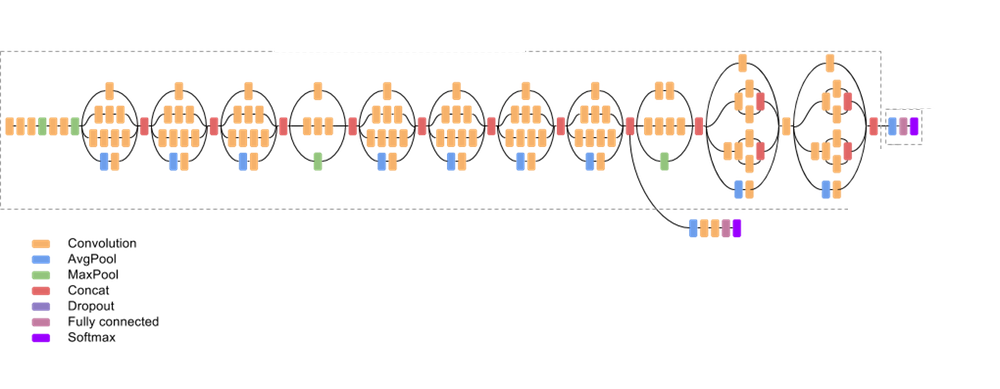

In [323]:
from idc_pathomics.data.data_set import Dataset
from idc_pathomics.model.inceptionv3_model import InceptionModel

output_dir_experiment = os.path.join(output_dir, time.strftime("%Y%m%d_%H%M%S"))
os.mkdir(output_dir_experiment)

# Load datasets
dataset_train = Dataset(os.path.join(input_dir, 'train_norm_luad_lscc_20_first130slides_9000tiles.csv'), num_classes=3)
dataset_valid = Dataset(os.path.join(input_dir, 'valid_norm_luad_lscc_20_first200slides_2.csv'), num_classes=3)

# Model set-up and training
model = InceptionModel(num_classes=3, input_shape=(128,128,3), learning_rate=0.1)
model.train(dataset_train, batch_size=512, epochs=30, output_path=output_dir_experiment, validation_dataset=dataset_valid) 

Epoch 1/30
17/17 [==============================] - 33s 2s/step - loss: 1.4147 - auc_25: 0.7141 - val_loss: 18229997568.0000 - val_auc_25: 0.5644
INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210927_150513/checkpoint_001/assets
Epoch 2/30
17/17 [==============================] - 22s 1s/step - loss: 1.1244 - auc_25: 0.8417 - val_loss: 3177076224.0000 - val_auc_25: 0.5644
INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210927_150513/checkpoint_002/assets
Epoch 3/30
17/17 [==============================] - 20s 1s/step - loss: 0.8598 - auc_25: 0.8512 - val_loss: 202777120.0000 - val_auc_25: 0.5644
INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210927_150513/checkpoint_003/assets
Epoch 4/30
17/17 [==============================] - 20s 1s/step - loss: 0.6771 - auc_25: 0.8743 - val_loss: 9630003.0000 - val_auc_25: 0.5644
INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210927_150513/checkpoint_004/assets
Epoch 5/30
17/17 [=============

### Evaluation

The final model is selected as the one with the best (minimal) loss on the validation dataset. The performance of this model is evaluated quantitatively by means of receiver operating characteristic (ROC) curves and observed qualitatively using heatmap visualization. First, the model makes predictions for the entire test set and stores them in the experiment's output directory to make subsequent evaluation easily repeatable. 

**ROC analysis** for each of the three classes (normal, LUAD, LSCC) is performed on **tile-level** (tile-based ROC) and on **slide-level** (slide-based ROC). For slide-level analysis the probabilities for each slide are aggregated either by averaging the probabilities of the corresponding tiles, or by counting the percentage of tiles positively classified. Respective Area under the ROC curve (AUC) values are reported in the table below and the slide-based ROC curves are visualized in Figure 4. In addition to the ROC curves for each class, a micro-average ROC is computed and visualized. 

**Heatmaps** for visually inspecting the network's predictions for some of the slides. The color of each tile corresponds to the class assigned by our model, with the hue indicating how confident the network is in this classification. Hereby a darker hue corresponds to higher confidence. The respective orginal WSI is shown as thumbnail image next to the heatmap. The generation of a thumbnail image takes ~1min, thus we limit ourselves to showing heatmaps for only 4 random slides from the testset. 

In [11]:
# Load the best model 
checkpoints = glob.glob(os.path.join(output_dir_experiment, 'checkpoint*/'))
checkpoints.sort()
best_model_dir = checkpoints[-1] # last checkpoint is the one with the best validation loss 
best_model = InceptionModel.load(best_model_dir)

2021-09-27 15:39:43.584311: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-27 15:39:43.690672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-27 15:39:43.691404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-27 15:39:43.692841: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [12]:
from idc_pathomics.evaluation.predictions import Predictions

test_dataset = Dataset(os.path.join(input_dir, 'test_norm_luad_lscc_10slide_20tile_2.csv'), num_classes=3)
#test_dataset = Dataset('/home/jupyter/idc_input_vm/test_norm_luad_lscc_10slide_20tile_2.csv', num_classes=3)

predictions = Predictions(best_model, test_dataset) 
predictions.save(os.path.join(output_dir_experiment, 'predictions_10slide_20tile_2.json'))

2021-09-27 15:40:08.545241: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


tile-based AUC     slide-based AUC                    
                      average probability percentage positive
Normal          0.682               0.827               0.802
LUAD            0.495               0.540               0.512
LUSC            0.738               0.808               0.858
Micro           0.661               0.708               0.716

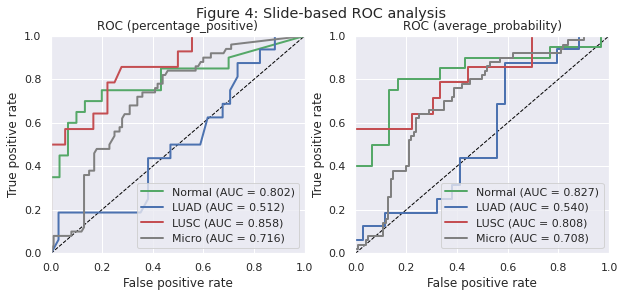

In [13]:
from idc_pathomics.evaluation.roc import ROCAnalysis

roc_analysis = ROCAnalysis(predictions)
roc_analysis.print_and_save_tabluar_results(os.path.join(output_dir_experiment, 'results_table_10slide_20tile_2.html'))
roc_analysis.plot_and_save(output_dir_experiment) 

In [ ]:
%%capture --no-display
from idc_pathomics.data.utils import get_random_testset_slide_ids, get_thumbnail, get_slide_tissue_type
from idc_pathomics.evaluation.heatmap import get_heatmap, plot_colormap_legend
from idc_pathomics.evaluation.predictions import Predictions

# Select slides and download thumbnails 
heatmap_slide_ids = get_random_testset_slide_ids(slides_metadata)
get_thumbnail(heatmap_slide_ids, slides_metadata_path, slides_dir, google_cloud_project_id=my_project_id) # NOTE: lasts ~1min per slide

# Generate figure 
plot_colormap_legend()
fig5, axes = plt.subplots(4, 2, figsize=(10, 9))
fig5.suptitle('Figure 5: Heatmap visualization')
for i in range(4):
    slide_id = heatmap_slide_ids[i]#'C3L-00913-22'#
    slide = plt.imread(os.path.join(slides_dir, slide_id + '.png'))
    true_tissue_type = get_slide_tissue_type(slide_id, slides_metadata)
    axes[i,0].imshow(get_heatmap(predictions, slide_id))
    axes[i,1].imshow(slide1)
    axes[i,1].set_title(true_tissue_type.upper())
    axes[i,0].axis('off')
    axes[i,1].axis('off')

Copying gs://idc_dev/c2627b06-f2c8-4117-b091-44c143803bdd.dcm...
| [1 files][172.8 MiB/172.8 MiB]                                                
Operation completed over 1 objects/172.8 MiB.                                    
